In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("data.csv")
print(df.shape)
df.columns = ['date', 'sales', 'stock', 'price']

df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

# Visual check
print(df.head())


(937, 4)
        date  sales  stock  price
0 2014-01-01      0   4972   1.29
1 2014-01-02     70   4902   1.29
2 2014-01-03     59   4843   1.29
3 2014-01-04     93   4750   1.29
4 2014-01-05     96   4654   1.29


In [2]:
# ------------------------
# Seasonal and Date Features
# ------------------------
df['dayofweek'] = df['date'].dt.dayofweek
df['dayofmonth'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# ------------------------
# Lag Features
# ------------------------
df['lag_1'] = df['sales'].shift(1)
df['lag_7'] = df['sales'].shift(7)
df['lag_14'] = df['sales'].shift(14)

# ------------------------
# Rolling Window Features
# ------------------------
df['rolling_mean_7'] = df['sales'].shift(1).rolling(window=7).mean()
df['rolling_std_7'] = df['sales'].shift(1).rolling(window=7).std()

# ------------------------
# Expanding Window
# ------------------------
df['expanding_mean'] = df['sales'].shift(1).expanding().mean()

# ------------------------
# Drop rows with NaNs
# ------------------------
df = df.dropna().reset_index(drop=True)

# Check shape again
print(df.shape)
print(df.columns) 


(923, 15)
Index(['date', 'sales', 'stock', 'price', 'dayofweek', 'dayofmonth', 'month',
       'weekofyear', 'is_weekend', 'lag_1', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_std_7', 'expanding_mean'],
      dtype='object')


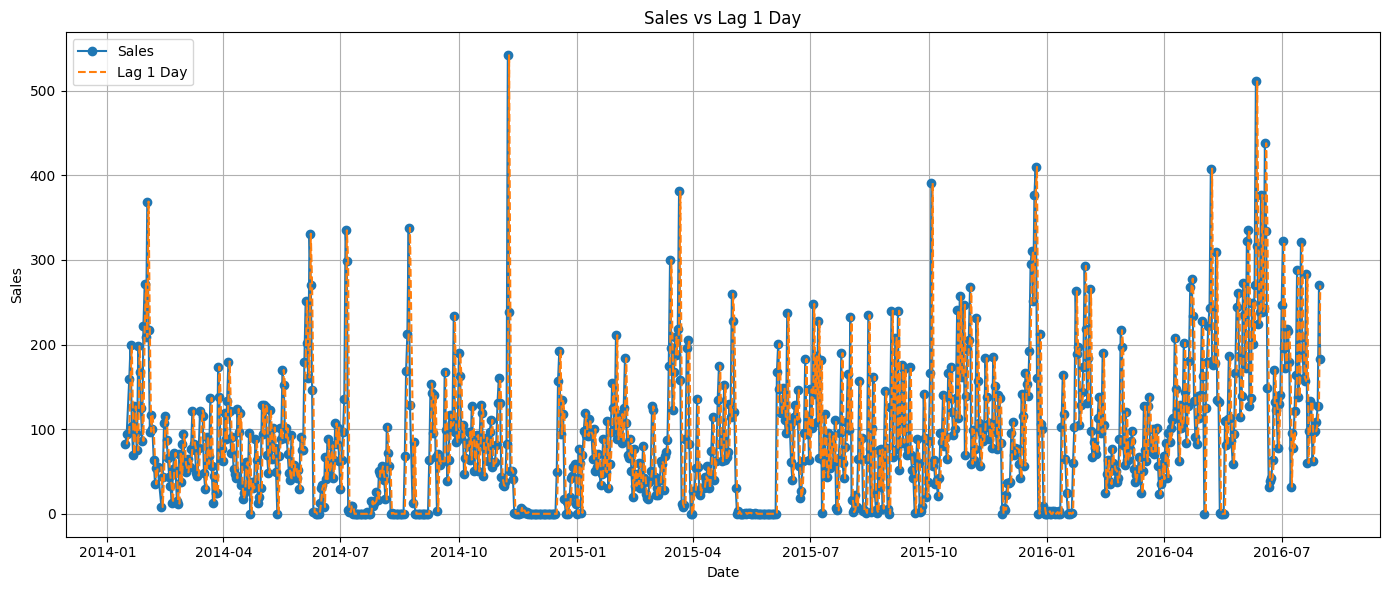

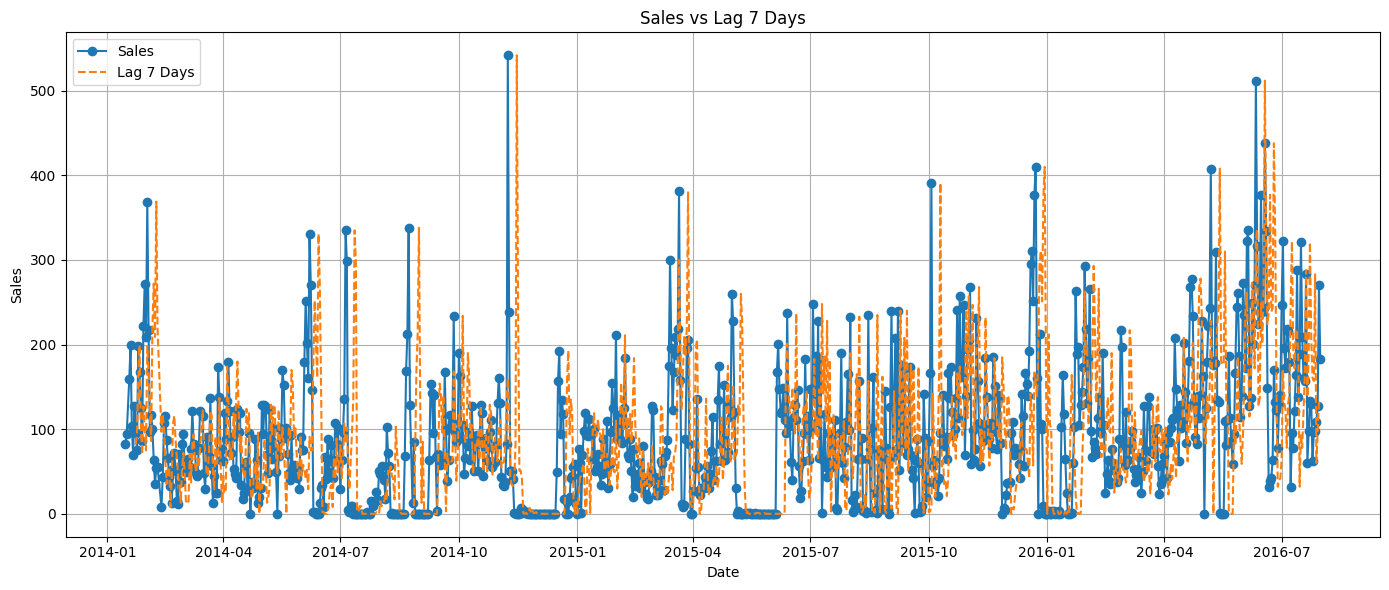

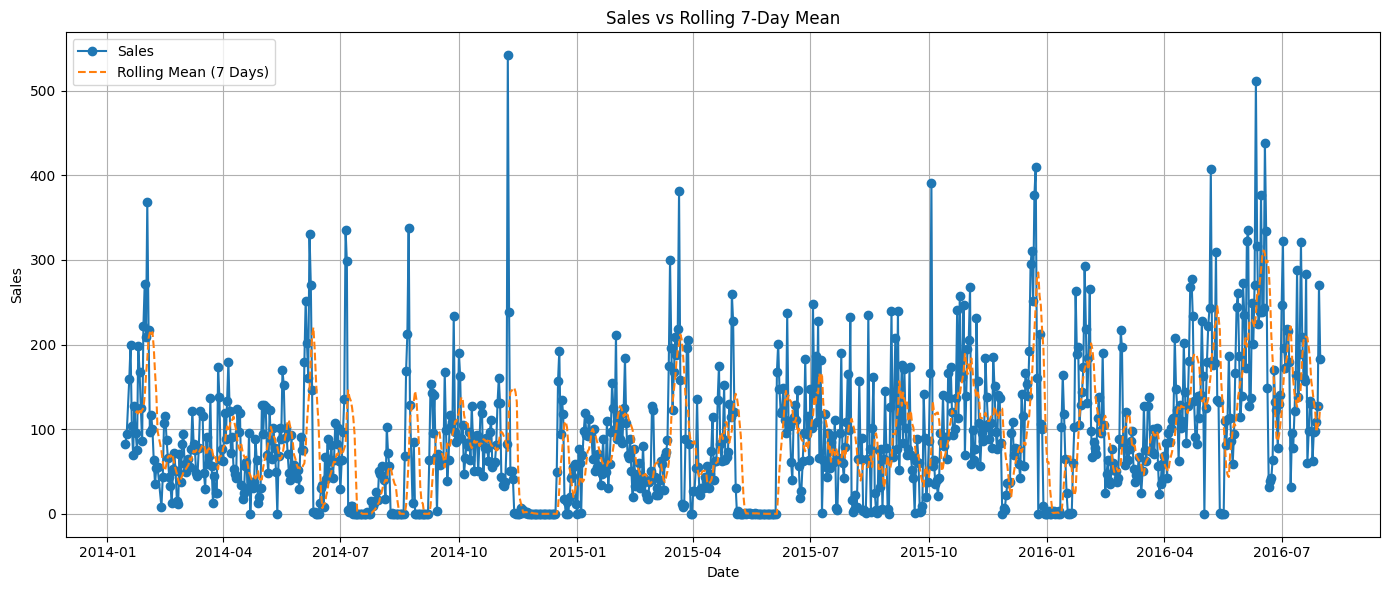

In [3]:
import matplotlib.pyplot as plt

# Plotting sales vs lag_1
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['sales'], label='Sales', marker='o')
plt.plot(df['date'], df['lag_1'], label='Lag 1 Day', linestyle='--')
plt.title('Sales vs Lag 1 Day')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting sales vs lag_7
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['sales'], label='Sales', marker='o')
plt.plot(df['date'], df['lag_7'], label='Lag 7 Days', linestyle='--')
plt.title('Sales vs Lag 7 Days')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting sales vs rolling mean
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['sales'], label='Sales', marker='o')
plt.plot(df['date'], df['rolling_mean_7'], label='Rolling Mean (7 Days)', linestyle='--')
plt.title('Sales vs Rolling 7-Day Mean')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [4]:
# Define sizes
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
test_size = len(df) - train_size - val_size

# Chronological split
train = df[:train_size]
val = df[train_size:train_size + val_size]
test = df[train_size + val_size:]

# Check shapes
print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)


Train shape: (646, 15)
Validation shape: (138, 15)
Test shape: (139, 15)


In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------------
# Step 1: Define Features & Target
# -------------------------------

# Drop columns that shouldn't be fed to the model
drop_cols = ['date', 'sales'] 

feature_cols = [col for col in train.columns if col not in drop_cols]

X_train = train[feature_cols]
y_train = train['sales']

X_val = val[feature_cols]
y_val = val['sales']

X_test = test[feature_cols]
y_test = test['sales']

# -------------------------------
# Step 2: Train XGBoost Regressor
# -------------------------------

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

# -------------------------------
# Step 3: Evaluate on Validation
# -------------------------------

val_preds = model.predict(X_val)

rmse_val = np.sqrt(mean_squared_error(y_val, val_preds))
mae_val = mean_absolute_error(y_val, val_preds)

print(f"Validation RMSE: {rmse_val:.2f}")
print(f"Validation MAE: {mae_val:.2f}")

# -------------------------------
# Step 4: Final Evaluation on Test Set
# -------------------------------

test_preds = model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
mae_test = mean_absolute_error(y_test, test_preds)

print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAE: {mae_test:.2f}")


Validation RMSE: 66.07
Validation MAE: 44.51
Test RMSE: 94.18
Test MAE: 69.77


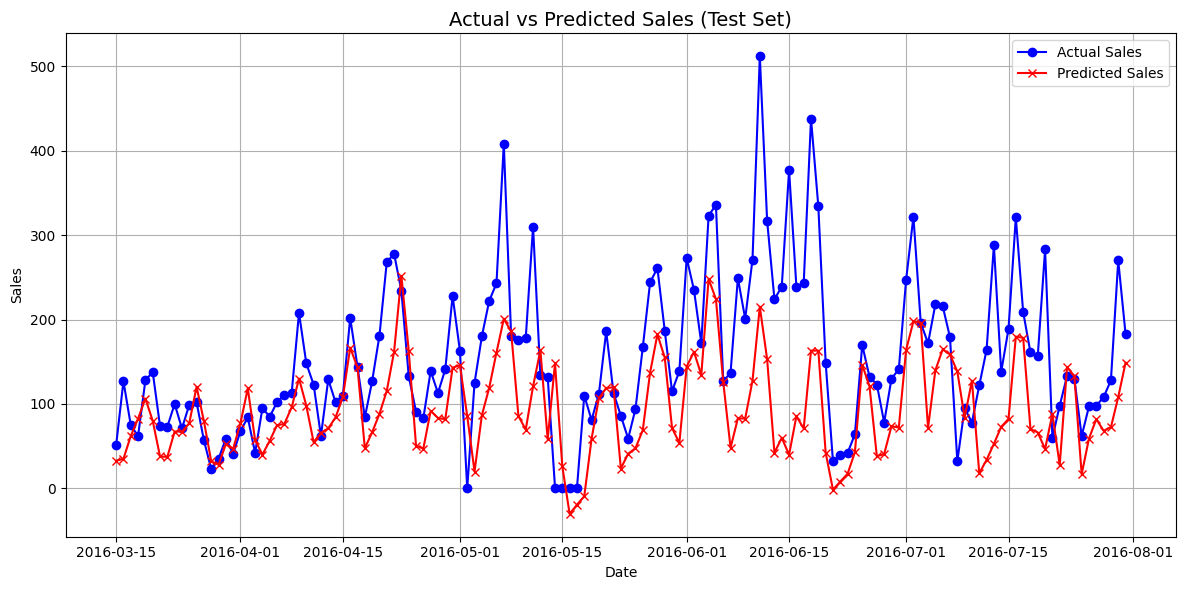

In [6]:
import matplotlib.pyplot as plt

# Create DataFrame for plotting
test_results = test.copy()
test_results['predicted_sales'] = test_preds

# Plot
plt.figure(figsize=(12,6))
plt.plot(test_results['date'], test_results['sales'], label='Actual Sales', color='blue', marker='o')
plt.plot(test_results['date'], test_results['predicted_sales'], label='Predicted Sales', color='red', marker='x')

plt.title('Actual vs Predicted Sales (Test Set)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
df['sales'].mean(), df['sales'].median(), df['sales'].min(), df['sales'].max()


(90.06608884073673, 75.0, 0, 542)